<a href="https://colab.research.google.com/github/mobley-trent/kaggle/blob/master/fruits_object_detection_with_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FRUIT OBJECT DETECTION USING FASTER R-CNN IN PYTORCH

Welcome to this Google Colab notebook where we will be working on object detection of fruits using the Faster R-CNN model. We will be using a dataset consisting of three types of fruits: bananas, oranges, and apples. Object detection is a fundamental task in computer vision, and we will be using a pre-trained model, `fasterrcnn_resnet50_fpn`, to perform object detection on our dataset. Furthermore, we will be utilizing non-maximum suppression to improve our detection results by removing redundant bounding boxes. By the end of this notebook, you will have a better understanding of how object detection works and how to use pre-trained models to perform this task on your own datasets.

In [1]:
from google.colab import files
files.upload() #upload kaggle.json

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

!kaggle kernels list — user YOUR_USER — sort-by dateRun

!kaggle datasets download -d mbkinaci/fruit-images-for-object-detection

Saving kaggle.json to kaggle.json
kaggle.json
usage: kaggle
       [-h]
       [-v]
       {competitions,c,datasets,d,kernels,k,config}
       ...
kaggle: error: unrecognized arguments: — user YOUR_USER — sort-by dateRun
 88% 25.0M/28.4M [00:01<00:00, 34.4MB/s]
100% 28.4M/28.4M [00:01<00:00, 22.7MB/s]


In [2]:
!unzip fruit-images-for-object-detection.zip

Archive:  fruit-images-for-object-detection.zip
  inflating: test_zip/test/apple_77.jpg  
  inflating: test_zip/test/apple_77.xml  
  inflating: test_zip/test/apple_78.jpg  
  inflating: test_zip/test/apple_78.xml  
  inflating: test_zip/test/apple_79.jpg  
  inflating: test_zip/test/apple_79.xml  
  inflating: test_zip/test/apple_80.jpg  
  inflating: test_zip/test/apple_80.xml  
  inflating: test_zip/test/apple_81.jpg  
  inflating: test_zip/test/apple_81.xml  
  inflating: test_zip/test/apple_82.jpg  
  inflating: test_zip/test/apple_82.xml  
  inflating: test_zip/test/apple_83.jpg  
  inflating: test_zip/test/apple_83.xml  
  inflating: test_zip/test/apple_84.jpg  
  inflating: test_zip/test/apple_84.xml  
  inflating: test_zip/test/apple_85.jpg  
  inflating: test_zip/test/apple_85.xml  
  inflating: test_zip/test/apple_86.jpg  
  inflating: test_zip/test/apple_86.xml  
  inflating: test_zip/test/apple_87.jpg  
  inflating: test_zip/test/apple_87.xml  
  inflating: test_zip/test/a

In [3]:
# Download TorchVision repo to use some files from
# references/detection
!pip install pycocotools --quiet
!git clone https://github.com/pytorch/vision.git
!git checkout v0.3.0

!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

Cloning into 'vision'...
remote: Enumerating objects: 320145, done.
remote: Counting objects: 100% (3172/3172), done.
remote: Compressing objects: 100% (152/152), done.
remote: Total 320145 (delta 3023), reused 3160 (delta 3015), pack-reused 316973
Receiving objects: 100% (320145/320145), 651.33 MiB | 8.87 MiB/s, done.
Resolving deltas: 100% (294365/294365), done.
fatal: not a git repository (or any of the parent directories): .git


In [4]:
# !pip install engine
# !pip install utils
# !pip install transforms

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement engine (from versions: none)
ERROR: No matching distribution found for engine
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for transforms: filename=transforms-0.1-py3-none-any.whl size=39350 sha256=02f3d25f676e4242bccd096caf5e5b65cb7c7e2d930ace0224f1de35e89acb6d
  Stored in directory: /root/.cache/pip/wheels/4e/78/13/104953e39581ccf9bc5119acfe63cf5b5491f8807235d6508c
Successfully built transforms


In [5]:
# Basic python and ML Libraries
import os
import random
import numpy as np
import pandas as pd
# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

import cv2 # We will be reading images using OpenCV
from xml.etree import ElementTree as et # for parsing xml files

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Helper libraries
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [6]:
files_dir = '/content/train_zip/train'
test_dir = '/content/test_zip/test'

class FruitImagesDataset(torch.utils.data.Dataset):

    def __init__(self, files_dir, width, height, transforms=None):
        self.transforms = transforms
        self.files_dir = files_dir
        self.height = height
        self.width = width
        
        # sorting the images for consistency
        # To get images, the extension of the filename is checked to be jpg
        self.imgs = [image for image in sorted(os.listdir(files_dir))
                        if image[-4:]=='.jpg']
        
        
        # classes: 0 index is reserved for background
        self.classes = [_, 'apple','banana','orange']

    def __getitem__(self, idx):

        img_name = self.imgs[idx]
        image_path = os.path.join(self.files_dir, img_name)

        # reading the images and converting them to correct size and color    
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        # diving by 255
        img_res /= 255.0
        
        # annotation file
        annot_filename = img_name[:-4] + '.xml'
        annot_file_path = os.path.join(self.files_dir, annot_filename)
        
        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()
        
        # cv2 image gives size as height x width
        wt = img.shape[1]
        ht = img.shape[0]
        
        # box coordinates for xml files are extracted and corrected for image size given
        for member in root.findall('object'):
            labels.append(self.classes.index(member.find('name').text))
            
            # bounding box
            xmin = int(member.find('bndbox').find('xmin').text)
            xmax = int(member.find('bndbox').find('xmax').text)
            
            ymin = int(member.find('bndbox').find('ymin').text)
            ymax = int(member.find('bndbox').find('ymax').text)
            
            
            xmin_corr = (xmin/wt)*self.width
            xmax_corr = (xmax/wt)*self.width
            ymin_corr = (ymin/ht)*self.height
            ymax_corr = (ymax/ht)*self.height
            
            boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
        
        # convert boxes into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # getting the areas of the boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # suppose all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        
        labels = torch.as_tensor(labels, dtype=torch.int64)


        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        # image_id
        image_id = torch.tensor([idx])
        target["image_id"] = image_id


        if self.transforms:
            
            sample = self.transforms(image = img_res,
                                     bboxes = target['boxes'],
                                     labels = labels)
            
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
            
            
        return img_res, target

    def __len__(self):
        return len(self.imgs)


# check dataset
dataset = FruitImagesDataset(files_dir, 224, 224)
print('length of dataset = ', len(dataset), '\n')

# getting the image and target for a test index.  Feel free to change the index.
img, target = dataset[78]
print(img.shape, '\n',target)

length of dataset =  240 

(224, 224, 3) 
 {'boxes': tensor([[ 22.4000,  36.4903, 163.1000,  68.6452],
        [ 24.8500,  39.3806, 163.4500,  94.2968],
        [ 28.0000,  52.3871, 166.9500, 127.8968],
        [ 71.0500,  59.6129, 193.9000, 157.5226]]), 'labels': tensor([2, 2, 2, 2]), 'area': tensor([ 4524.1865,  7611.3750, 10492.0693, 12028.2041]), 'iscrowd': tensor([0, 0, 0, 0]), 'image_id': tensor([78])}


This code defines a custom dataset class called `FruitImagesDataset` which inherits from the PyTorch `Dataset` class. The dataset is designed to work with a set of images of fruits and corresponding annotation files. The dataset contains images and their corresponding bounding boxes that indicate where the fruits are located within the image.

When the FruitImagesDataset object is instantiated with a files directory, width, and height, it sorts the images for consistency, converts the images to the correct size and color, and loads the annotation files. The images and annotation information are returned in a format that can be used by PyTorch's DataLoader for training machine learning models.

- The dataset returns a tuple; the first element is the image shape and the second element is a dictionary.
- The image is of the size we provided while defining the dataset and the color mode is RGB.
- There are four bounding boxes in the image which is evident from the four lists in `boxes` and length of `labels`.

## VISUALIZATION

In [7]:
# Function to visualize bounding boxes in the image

def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')
        
        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()

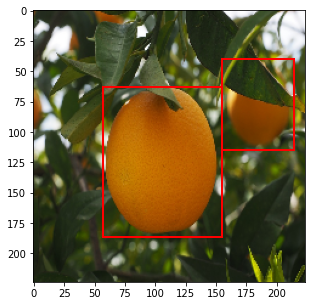

In [8]:
# plotting the image with bboxes. Feel free to change the index
img, target = dataset[201]
plot_img_bbox(img, target)

## MODEL

In [9]:
# Function for loading the model. Will be used further in the pipeline.

def get_object_detection_model(num_classes):

    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

    return model

## AUGMENTATIONS

In [10]:
# Send train=True fro training transforms and False for val/test transforms
def get_transform(train):
    
    if train:
        return A.Compose([
                            A.HorizontalFlip(0.5),
                     # ToTensorV2 converts image to pytorch tensor without div by 255
                            ToTensorV2(p=1.0) 
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

We define a function `get_transform()` that returns a set of image augmentations as an object of the `albumentations` library. The function takes a boolean argument `train` that determines whether the function returns the training transforms or the validation/test transforms.

If `train=True`, the function returns the following data augmentations for training images:
- HorizontalFlip: randomly flips the image horizontally with a probability of 0.5.
- ToTensorV2: converts the image to a PyTorch tensor and normalizes the pixel values to be between 0 and 1.

If `train=False`, the function returns only the ToTensorV2 transformation, which converts the image to a PyTorch tensor and normalizes the pixel values to be between 0 and 1.

In addition, the function also sets the bounding box format as "pascal_voc" and specifies the label field as "labels" for both sets of transforms.

## DATA PREPROCESSING

In [11]:
# use our dataset and defined transformations
dataset = FruitImagesDataset(files_dir, 480, 480, transforms= get_transform(train=True))
dataset_test = FruitImagesDataset(files_dir, 480, 480, transforms= get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

# train test split
test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=10, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=10, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

## TRAINING

In [12]:
# to train on gpu if selected.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


num_classes = 4

# get the model using our helper function
model = get_object_detection_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [13]:
# training for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/20]  eta: 0:05:03  lr: 0.000268  loss: 1.5074 (1.5074)  loss_classifier: 1.2604 (1.2604)  loss_box_reg: 0.2377 (0.2377)  loss_objectness: 0.0044 (0.0044)  loss_rpn_box_reg: 0.0049 (0.0049)  time: 15.1546  data: 4.8040  max mem: 8205
Epoch: [0]  [10/20]  eta: 0:00:30  lr: 0.002897  loss: 0.9368 (0.9941)  loss_classifier: 0.5418 (0.6873)  loss_box_reg: 0.2697 (0.2964)  loss_objectness: 0.0041 (0.0046)  loss_rpn_box_reg: 0.0052 (0.0059)  time: 3.0472  data: 0.4696  max mem: 8473
Epoch: [0]  [19/20]  eta: 0:00:02  lr: 0.005000  loss: 0.6448 (0.7456)  loss_classifier: 0.3366 (0.4675)  loss_box_reg: 0.2377 (0.2661)  loss_objectness: 0.0044 (0.0057)  loss_rpn_box_reg: 0.0052 (0.0062)  time: 2.4658  data: 0.2720  max mem: 8473
Epoch: [0] Total time: 0:00:49 (2.4699 s / it)
creating index...
index created!
Test:  [0/5]  eta: 0:00:09  model_time: 0.9214 (0.9214)  evaluator_time: 0.0622 (0.0622)  time: 1.9623  data: 0.9412  max mem: 8473
Test:  [4/5]  eta: 0:00:01  model_time: 0.8

The evaluation results show the average precision and recall of the model at various Intersection over Union (IoU) thresholds for different object sizes and detection limits (maxDets). The average precision and recall are measures of how well the model is able to detect objects in the test set. The IoU threshold specifies how much overlap there needs to be between the predicted bounding box and the ground truth bounding box for it to be considered a correct detection. The area parameter specifies the size of the objects being detected (small, medium, or large).

In this case, the model achieved an average precision of 0.519 for all objects with an IoU threshold of 0.5 to 0.95, and a recall of 0.633 for the same threshold and all objects. However, for small and medium objects, the model was not able to achieve a meaningful average precision or recall.

## DECODE PREDICTIONS

Our model predicts a lot of bounding boxes per image, to take out the overlapping ones, We will use [**Non Max Suppression**](https://towardsdatascience.com/non-maximum-suppression-nms-93ce178e177c)

Torchvision provides us a utility to apply nms to our predictions, lets build a function `apply_nms` using that.

In [14]:
# the function takes the original prediction and the iou threshold.

def apply_nms(orig_prediction, iou_thresh=0.3):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

## TEST THE MODEL

In [15]:
# pick one image from the test set
img, target = dataset_test[5]

# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted # boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

predicted # boxes:  14
real #boxes:  1


In [16]:
prediction

{'boxes': tensor([[ 61.2029,  98.0812, 265.0255, 386.8562],
         [191.6516, 101.8145, 315.4326, 369.2085],
         [222.9939, 143.3630, 449.6528, 396.0480],
         [ 77.4262,  42.3928, 441.3201, 404.2826],
         [ 49.3119, 122.8917, 423.8429, 427.9717],
         [154.9239,  70.1597, 353.3071, 417.6960],
         [219.8286, 122.4041, 462.5690, 461.3153],
         [142.0943,  58.4043, 352.0984, 456.9451],
         [ 75.7520,  56.7903, 274.4214, 465.5209],
         [167.9008, 101.3007, 441.5921, 395.6209],
         [205.9366,  97.8071, 341.9937, 402.1899],
         [ 43.3222,  60.0291, 267.3872, 400.6040],
         [164.3123, 118.1532, 311.6446, 329.3825],
         [174.9739,  74.2548, 307.8136, 366.3134]], device='cuda:0'),
 'labels': tensor([3, 3, 3, 3, 2, 3, 2, 2, 2, 1, 2, 1, 2, 1], device='cuda:0'),
 'scores': tensor([0.8592, 0.7733, 0.7232, 0.4505, 0.3654, 0.2479, 0.2476, 0.2031, 0.1950,
         0.1699, 0.1604, 0.1576, 0.0748, 0.0609], device='cuda:0')}

In [17]:
# Loading the tensors to CPU
for key in prediction.keys():
    prediction[key] = prediction[key].cpu()

EXPECTED OUTPUT


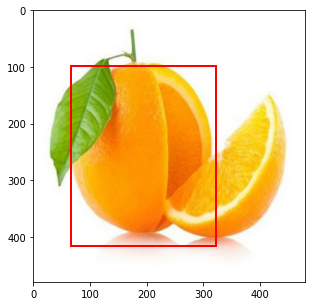

In [18]:
print('EXPECTED OUTPUT')
plot_img_bbox(torch_to_pil(img), target)

MODEL OUTPUT


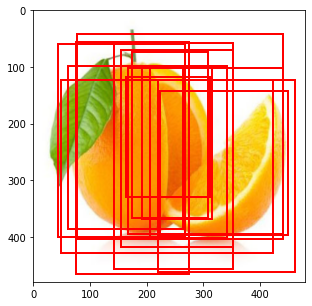

In [19]:
print('MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), prediction)

NMS APPLIED MODEL OUTPUT


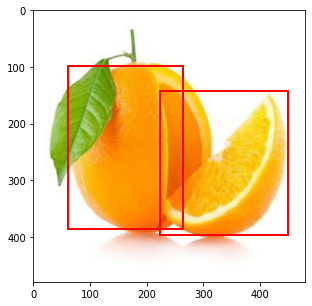

In [20]:
nms_prediction = apply_nms(prediction, iou_thresh=0.2)
print('NMS APPLIED MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), nms_prediction)

EXPECTED OUTPUT



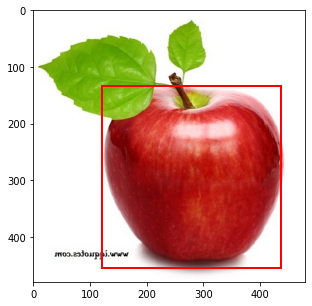

MODEL OUTPUT



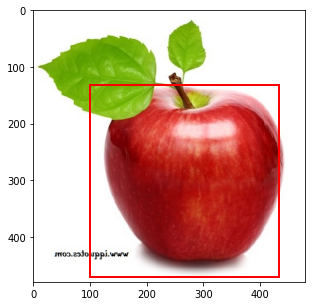

In [21]:
test_dataset = FruitImagesDataset(test_dir, 480, 480, transforms= get_transform(train=True))
# pick one image from the test set
img, target = test_dataset[10]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]

for key in prediction.keys():
    prediction[key] = prediction[key].cpu()

print('EXPECTED OUTPUT\n')
plot_img_bbox(torch_to_pil(img), target)
print('MODEL OUTPUT\n')
nms_prediction = apply_nms(prediction, iou_thresh=0.01)

plot_img_bbox(torch_to_pil(img), nms_prediction)